# Simulation Script

This file contains detailed explanations of simulaiton codes.

### Imports:

Here you will need sim_fractal file to run this notebook. This will be in the same directory, so you can direclty run this notebook. That file contains green function solutions which will be needed to determine faults movement.

In [1]:
import os.path
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates  as pdt
from scipy.interpolate import griddata
from pyrocko import gf
import sim_fractal as frct

## Let's start:

In the below cell, we define **store_id**. 

This store_id is used by pyrocko to download necessary file. In our case **store_id** is  **'gfs_ismetpasa'** since we are going to validate our results using real ismetpaşa data.

**Caution**: This function will download the file only if 'gfs_ismetpasa' is not in the same directory. In our case, we have provided the data for you, so you don't need to download the data. So, although you will run the below cell, it will not download the data.

In [2]:
# Download a Greens Functions store
store_id = 'gfs_ismetpasa' 
if not os.path.exists(store_id):
    gf.ws.download_gf_store(site='kinherd', store_id=store_id)

In [3]:
# Setup the LocalEngine and point it to the fomosto store you just downloaded.
# *store_superdirs* is a list of directories where to look for GF Stores.
engine = gf.LocalEngine(store_superdirs=['.'])

Again, we are defining some constant. Here, slip corresponds to slip amount of three different layers. Each slip value is in mm.


**Caution:** All of those constants are defined for one year period. In case you want to determine slip amounts for a smaller interval you should divide the slip value with 365.25 and  multiply with lenght of time interval in terms of day. 

$$ \text{slip for specific interval} = \frac{\text{slip  value}}{365.25}* \text{time interval}$$

In [4]:
km = 1e3       # for convenience
yr = 365.25    # year length in day
slip = [0.022, 0.015, 0.005] #slip values in mm
print(slip)

[0.022, 0.015, 0.005]


Here, we are creating temporal table, which gives information about our time flow.

Here, 
* Ndate,   how many image will be produced
* TempRsl, Temporal resolution, how long it takes for satellite to come back, in terms of day, 
* maxPB,   Perpendicular Baseline, the perpendicular distance between two passing of satellite from the same location.

**Caution**: Although we know our model accepts images in 9 batches, here we produce 10 batches. This is because the first image produced will be empty. 

In [5]:
Ndate   = 10 
TempRsl = 72 
maxPB   = 250

TempTbl = np.linspace(0, Ndate-1, Ndate) * TempRsl
PerpBsl = np.random.randint(-maxPB, maxPB,size=Ndate)

In [6]:
TempTbl

array([  0.,  72., 144., 216., 288., 360., 432., 504., 576., 648.])

As you see we have created a temporal table with 72 day interval.

Below, we are giving the inital time for the first image. Then using temporal table, we get the date for other passings of the satellite.

* PrmDt, data of first image
* PrmNum, PrmDt in terms of day
* ifgsNum, dates of interferogram shots, in terms of day
* ifgsDtNum, dates of interferogra shots, in terms of date


In [7]:
Prm = 0
PrmDt = '2018-05-12'

TempTbl   = np.subtract(TempTbl,TempTbl[Prm])
PrmNum    = pdt.datestr2num(PrmDt) 
ifgsNum   = np.add(TempTbl,PrmNum)
ifgsDtNum = pdt.num2date(ifgsNum)
ifgsDt = []

for i in range(len(TempTbl)):
	ifgDt = str(ifgsDtNum[i].year)+'-'+str(ifgsDtNum[i].month)+'-'+str(ifgsDtNum[i].day)
	ifgsDt.append(ifgDt)

PerpBsl[Prm] = 0

In some faults, we see creeps which last for some time and then stop and start moving again. 
Here we are calculating the displacement (in mm) for each creeping pathes and then outputs the sum of all the displacements. 


Here,
* step, time between two creep 
* N, length of episodic creep events in day
* crpSlip, slip amount
* X, array for interferogram days
* Y, show the maount of displacement

In [8]:
###   Calculate Episodic Creep events 
step = 60
N = 5 
crpSlip  = slip[2]/N   
crpStart = np.arange(2*N,int(np.max(ifgsNum))-int(np.min(ifgsNum))-3, step)
X =  np.arange(1,int(np.max(ifgsNum))-int(np.min(ifgsNum)))
Y = np.zeros(len(X), np.float32)  

for i in crpStart:
	Y[i-N:i+N] = np.logical_and(X[i-N:i+N]>=i-int(N/2),X[i-N:i+N]<=i+int(N/2)-1)
	Y[i-N:i+N] = Y[i-N:i+N] * np.bartlett((i+N)-(i-N))*crpSlip


In [9]:
ifgsNum

array([17663., 17735., 17807., 17879., 17951., 18023., 18095., 18167.,
       18239., 18311.])

In [10]:
crpStart

array([ 10,  70, 130, 190, 250, 310, 370, 430, 490, 550, 610])

In [11]:
#X

In [12]:
#Y

Here we are just defining coordinate system.

For example, in the code below, our pixel will cover an area of 20 km-20km East-West, and 20km-20 km North-South

In [13]:
###  Geographic (Ellipsoidal) Coordinate System 
E = [-20*km, 20*km] 
N = [-20*km, 20*km]

grdSize      = 1*km  #pixel size
Egrid, Ngrid = np.mgrid[E[0]:E[1]:grdSize, N[0]:N[1]:grdSize]
Esize, Nsize = Egrid.shape

In the below, you will find details to define satellite object. We initialize the satellite target and set the line of sight vectors direction. 

* look, angle between the LOS and the vertical, the difference between the first and second index must be at least 20 degrees.
* heading, angle between the azimuth and the North (anti-clock), here it is defined for 3 satellite, plus and minus corresponds to ascending and descending motion of satellite.
* lookA, look angle converted into radian



In [14]:
look    = [33., 54]
heading = [-166, -90, -14, 14, 90, 166] 
                                        
###  look angel is converted to Radian
lookA = np.tile(np.linspace(np.deg2rad(look[0]), np.deg2rad(look[1]), Esize), Nsize)  # vertical LOS from horizontal

Now, we are going to calculate position of satellites. 

In [15]:
STLT=[] 
for i in range(len(heading)):
    phi = np.empty(Esize*Nsize)    # horizontal LOS from E in anti-clokwise rotation
    phi.fill(np.deg2rad(heading[i-1]))
    satellite_target = gf.SatelliteTarget(north_shifts=Ngrid,east_shifts=Egrid,tsnapshot=24. * 3600.,  # one day
                                    interpolation='nearest_neighbor', phi=phi,theta=lookA,store_id=store_id)
    STLT.append(satellite_target)

Here we are defining some properties of fault.
* L[0] -> lenght of inersiesmic part // L[1] -> length of creeping patches,
    * L in general define lenght of creeping patches
* Wdth, width of fault
* Dpth, distance of fault from the ground
* strk, strike, the angle between the North and fault
* dp, dip angle, angle between the fault and the normal to the ground
* rk, rake, angle between the horizon of fault plane and the motion

In [16]:
L = np.multiply([50, 5], km) 
Wdth = np.multiply([100., 5.], km); 
Dpth = [Wdth[0]/2+10*km, Wdth[1]/2+0.5*km]
strk=80.; dp=89.; rk=160.; Nshift = 5; crpMax = slip[1]; epsCrpId = [3,6];

CRP = np.zeros((Nshift*2-1), np.float32)
CRP[0] = crpMax
shift = np.zeros((Nshift*2-1,2), np.float32)
n = 1
for i in range(1, len(shift),2):
	step = n*L[1]
	CRP[i] = crpMax - (n*(crpMax/Nshift))
	CRP[i+1] = crpMax - (n*(crpMax/Nshift))
	shift[i,:] = np.multiply(step,[np.cos(np.deg2rad(90 - strk)), np.sin(np.deg2rad(90 - strk))])
	shift[i+1,:] = np.multiply(step*-1,[np.cos(np.deg2rad(90 - strk)), np.sin(np.deg2rad(90 - strk))])
	n += 1


Now is the fun part. Here we are starting to calculate interferograms. 

In [17]:
VlosUltimate = []
for i in range(5):
    
    satellite_target=STLT[i%6] #we are assigning the satellite. 
    Vlos=[]
    target=0
    for ifg in np.arange(len(TempTbl)): #now, since we are creating batches of 10 interferograms this should be 
                                        #equal to the number of interferograms in a batch.
        t = np.abs(TempTbl[ifg])
        if ifg == 0:
            continue

        intSlip = (slip[0]/yr)*t
        if   ifg < Prm:
            epsCrp  = np.sum(Y[ifg:Prm])
        elif ifg > Prm:
            epsCrp  = np.sum(Y[Prm:int(t)])

        start = timer()

        intS_source = gf.RectangularSource( lat=0., lon=0., north_shift=0., east_shift=0.,
                    depth=Dpth[0], width=Wdth[0], length=L[0], dip=dp, rake=rk, strike=strk, slip=intSlip)
        intS_result = engine.process(intS_source, [satellite_target])
        lat = intS_result.request.targets[target].coords5[:, 2]/km
        lon = intS_result.request.targets[target].coords5[:, 3]/km
        intS_los = intS_result.results_list[0][target].result['displacement.los']
    
        crp_los = np.zeros(Esize*Nsize, np.float32)
        for i in range(len(CRP)):
            if (i in epsCrpId):
                continue

            crp = CRP[i]/yr*t
            patchCrp_source = gf.RectangularSource( lat=0, lon=0, north_shift=shift[i,1], east_shift=shift[i,0],
                    depth=Dpth[1], width=Wdth[1], length=L[1], dip=dp, rake=rk, strike=strk, slip=crp)
            patchCrp_result = engine.process(patchCrp_source, [satellite_target])
            patchCrp_los = patchCrp_result.results_list[0][target].result
            crp_los = crp_los + patchCrp_los['displacement.los']


        epsCrp_los = np.zeros(Esize*Nsize, np.float32)
        sorce_ne   = np.zeros((5,len(epsCrpId)*2), np.float32)
        for i in range(len(epsCrpId)):
            patchEpsCrp_source = gf.RectangularSource( lat=0, lon=0, north_shift=shift[epsCrpId[i],1], east_shift=shift[epsCrpId[i],0],
                    depth=Dpth[1], width=Wdth[1], length=L[1], dip=dp, rake=rk, strike=strk, slip=epsCrp)
            patchEpsCrp_result = engine.process(patchEpsCrp_source, [satellite_target])
            patchEpsCrp_los = patchEpsCrp_result.results_list[0][target].result
            epsCrp_los = epsCrp_los + patchEpsCrp_los['displacement.los']
            sorce_ne[:,i*2], sorce_ne[:,i*2+1] = patchEpsCrp_source.outline(cs='xy').T/km

        Dlos = (intS_los + crp_los + epsCrp_los)*km
        Vlos.append(Dlos)
        
    VlosUltimate.append(np.array(Vlos).reshape((9,40,40)))

Below cell creates tropospheric noise.

In [18]:
###  Tropospheri Turbulance 

trbc_list  = []
for i in range(180):
    
    trbl = frct.fractal_surface_atmos(shape=(Nsize, Esize), resolution=grdSize/10, p0=1.00, freq0=1e-3,
                                      regime=(0.01, 0.9999, 1.0), beta=(5./3., 8./3., 2./3.))
    trbc_list.append(trbl)


## Just for sanity check

### Just displacement

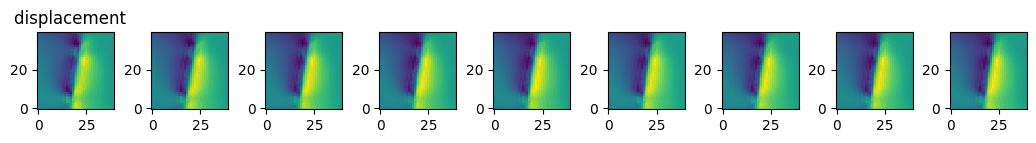

In [19]:
fig, (s0,s1,s2,s3,s4,s5,s6,s7,s8) = plt.subplots(1, 9, figsize = (13,1))
i=3
s0.title.set_text('displacement  ')
s0.imshow(VlosUltimate[i][0], interpolation="nearest")
s0.invert_yaxis()
s1.imshow(VlosUltimate[i][1].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s1.invert_yaxis()
s2.imshow(VlosUltimate[i][2].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s2.invert_yaxis()
s3.imshow(VlosUltimate[i][3].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s3.invert_yaxis()
s4.imshow(VlosUltimate[i][4].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s4.invert_yaxis()
s5.imshow(VlosUltimate[i][5].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s5.invert_yaxis()
s6.imshow(VlosUltimate[i][6].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s6.invert_yaxis()
s7.imshow(VlosUltimate[i][7].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s7.invert_yaxis()
s8.imshow(VlosUltimate[i][8].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s8.invert_yaxis()

plt.show()



### displacement + noise

In [20]:
new_data = np.zeros((5,9,40,40))
for i in range(45):
    new_data[i//9][i - (i//9) * 9] = np.array(trbc_list[i]) + np.array(VlosUltimate[i//9][i - (i//9) * 9])

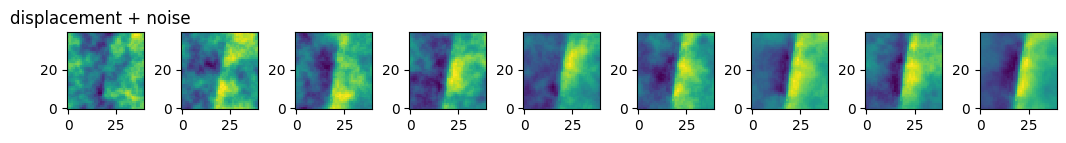

In [21]:
fig, (s0,s1,s2,s3,s4,s5,s6,s7,s8) = plt.subplots(1, 9, figsize = (13,1))
i=4
s0.title.set_text('displacement + noise  ')
s0.imshow(new_data[i][0], interpolation="nearest")
s0.invert_yaxis()
s1.imshow(new_data[i][1], interpolation="nearest")
s1.invert_yaxis()
s2.imshow(new_data[i][2], interpolation="nearest")
s2.invert_yaxis()
s3.imshow(new_data[i][3], interpolation="nearest")
s3.invert_yaxis()
s4.imshow(new_data[i][4], interpolation="nearest")
s4.invert_yaxis()
s5.imshow(new_data[i][5], interpolation="nearest")
s5.invert_yaxis()
s6.imshow(new_data[i][6], interpolation="nearest")
s6.invert_yaxis()
s7.imshow(new_data[i][7], interpolation="nearest")
s7.invert_yaxis()
s8.imshow(new_data[i][8], interpolation="nearest")
s8.invert_yaxis()

plt.show()